In [55]:
import psycopg2
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
import datetime as dt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from sklearn.decomposition import LatentDirichletAllocation

# see a 2d representation of the data using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

from sklearn.cluster import KMeans

In [56]:
plt.rcParams['font.family'] = 'Ubuntu'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['figure.figsize'] = [10,6]

seven_colors = ['#001d8f','#774cb2','#bf84d6','#ffc3ff','#f995cd','#ed6892','#d43d51']

five_colors_purp_red = ['#001d8f','#9c67c4','#ffc3ff','#f47fb0','#d43d51']

five_colors_blue_red = ['#0ca7c9','#9ebdf3','#f6d5ff','#ee8ab8','#d43d51']

five_dark_blue_yellow = ['#003f5c','#58508d','#bc5090','#ff6361','#ffa600']

asd = ['#6ca3bd','#afbcea','#ffd2ff','#f288b4','#d43d51']

five_green_red = ['#13bdb4',
'#80d090',
'#dad977',
'#e49046',
'#d43d51']

palette = five_green_red

In [57]:
class NlpProcessor(object):

    def __init__(self, log_file_path):
        self.conn = self.open_conn()
        self.log_file_path = log_file_path

    def open_conn(self):
        return psycopg2.connect(dbname='therapist_predictor', user='postgres', host='localhost', password='password')

    def close_conn(self):
        self.conn = None

    def sql_to_pandas(self, sql:str)->pd.DataFrame:
        df = pd.read_sql_query(sql, self.conn)

        return df

    # tokenizing with nltk, with stemming/lemmatizing
    # this keeps punctuation
    def tokenize_doc(self, set_of_docs)->list:
        return [word_tokenize(content.lower()) for content in set_of_docs ]

    def remove_stopwords_and_punc(self, tokenized_set_of_docs:list, stop_words, remove_punc=True)->list:
        no_stops_docs = []
        for tokens in tokenized_set_of_docs:
            saved_tokens = []
            for token in tokens:
                if remove_punc:
                    if token.isalpha():
                        if token not in stop_words:
                            saved_tokens.append(token)
                else:
                    if token not in stop_words:
                        saved_tokens.append(token)
            no_stops_docs.append(saved_tokens)
            #no_stops_docs.append([word for word in words if word not in final_stop_words and word])
        
        return no_stops_docs

    def stem_porter(self, tokenized_set_of_docs:list)->list:
        porter = PorterStemmer()
        porter_docs = []
        for words in tokenized_set_of_docs:
            porter_docs.append([porter.stem(word) for word in words])
        
        return porter_docs

    def stem_snowball(self, tokenized_set_of_docs:list)->list:
        snowball = SnowballStemmer('english')
        snowball_docs = []
        for words in tokenized_set_of_docs:
            snowball_docs.append([snowball.stem(word) for word in words])
        
        return snowball_docs

    def lemm_wordnet(self, tokenized_set_of_docs:list)->list:
        wordnet = WordNetLemmatizer()
        wordnet_docs = []
        for words in tokenized_set_of_docs:
            wordnet_docs.append([wordnet.lemmatize(word) for word in words])
        
        return wordnet_docs

    def text_tokenization_pipeline(self, list_of_docs : list, stop_words, remove_punc : bool, tokenizer='wordnet') -> list:
        tokenized_docs = self.tokenize_doc(list_of_docs)
        no_stops_docs = self.remove_stopwords_and_punc(tokenized_docs, stop_words, remove_punc=remove_punc)
        lemm_stemm_docs = []
        if tokenizer == 'wordnet':
            lemm_stemm_docs = self.lemm_wordnet(no_stops_docs)
        elif tokenizer == 'porter':
            lemm_stemm_docs = self.stem_porter(no_stops_docs)
        elif tokenizer == 'snowball':
            lemm_stemm_docs = self.stem_snowball(no_stops_docs)
        else:
            lemm_stemm_docs = no_stops_docs
            
        return lemm_stemm_docs

    def remove_dupes_decorator(self, func):
        def func_wrapper(*args, **kwargs):
            dupes_removed_docs = func(*args, **kwargs)
            
            return [list(set(ls)) for ls in dupes_removed_docs]

        return func_wrapper

    def combine_stop_words(self, custom_stop_words:list)->list:
        stop_words = set(stopwords.words('english'))

        return stop_words.union(custom_stop_words)

    def create_term_freqeuncy_matrix(self, df:pd.DataFrame, all_stop_words:list, n_gram_range, max_features, remove_punc=True, tokenizer='None'):
        tokens = self.text_tokenization_pipeline(df['writing_sample'],stop_words=all_stop_words,
                                                remove_punc=True, tokenizer='none')

        documents = [' '.join(doc) for doc in tokens]

        # tfidf_vect = TfidfVectorizer(lowercase=False)
        # tfidf_matrix = tfidf_vect.fit_transform(documents)
        #print(tfidf_vect.get_feature_names())

        count_vect = CountVectorizer(max_features=max_features, ngram_range=n_gram_range)
        tf_matrix = count_vect.fit_transform(documents)

        return tf_matrix, count_vect

    def get_most_freq_words(self, count_vectorizer, tf_matrix, num_words, print_dict_to_terminal=False):
        top_words = []
        word_freqs = []
        
        word_list = count_vect.get_feature_names()
        count_list = tf_matrix.toarray().sum(axis=0)

        #combine these in a dictionary
        word_freq_dict = dict(zip(word_list, count_list))
        
        # dictionary.values() and .keys() return a view object, so we have to cast it to list in order to use it as desired
        for word_index in np.argsort(list(word_freq_dict.values()))[-num_words:]:
            top_words.append(list(word_freq_dict.keys())[word_index])
            word_freqs.append(list(word_freq_dict.values())[word_index])
            print('\n')
            if print_dict_to_terminal:
                print(f'{list(word_freq_dict.keys())[word_index]} : {list(word_freq_dict.values())[word_index]}')
            
        return top_words, word_freqs
        
    def display_topics(self, model, feature_names, num_top_n_grams, custom_stopwords, log=True)->None:
        topic_ngram_dict = {}

        for topic_idx, topic in enumerate(model.components_):
            topic_header = "Topic %d:" % (topic_idx)
            print(topic_header)
            single_topic_n_grams = []
            for i in topic.argsort()[:-num_top_n_grams - 1:-1]:
                single_topic_n_grams.append(feature_names[i]) 

            print(single_topic_n_grams)
            topic_ngram_dict[topic_idx] = single_topic_n_grams
        if log:
            self.log_lda_results(model.get_params(), topic_ngram_dict, custom_stopwords)

    def log_lda_results(self, model_params:dict, topic_ngram_dict:dict, custom_stopwords:list)->None:
        file_log = open(self.log_file_path, 'a')

        header = '\n\n**************************************** LDA Results ****************************************'
        date_and_time = 'Timestamp: ' + str(dt.datetime.now())
        model_params_header = '\nModel Parameters: \n-------------------------'
        params_str = ''
        for k, v in model_params.items():
            params_str += f'{k} : {v}\n'

        stopwords_header = 'Stop words used:'
        stopwords_str = ', '.join([stop for stop in custom_stopwords])
        stopwords_str += '\n'

        L = [header, date_and_time, model_params_header, params_str, stopwords_header, stopwords_str]

        for topic_idx, n_gram_list in topic_ngram_dict.items():
            L.append(f'Topic: {str(topic_idx)}\n\t{", ".join([ng for ng in n_gram_list])}')
        # topics = ''
        # for i, words in enumerate(topic_words_list):
        #     topics += f'Topic {i+1}\n\t{words}'

        for i in range(len(L)):
            L[i] += '\n'
        file_log.writelines(L)
        file_log.close()

# Tokenizing Data

In [58]:
nlp = NlpProcessor(log_file_path='../logs/lda_results_log.txt')

sql = "select * from therapists;"
df = nlp.sql_to_pandas(sql)

sql_age = 'SELECT * FROM age_groups;'
sql_issues = 'SELECT  * FROM issues;'
sql_orientations = 'SELECT * FROM orientations'
sql_professions = 'SELECT * FROM professions'
sql_services = 'SELECT * FROM services'

df_age_groups = nlp.sql_to_pandas(sql_age)
df_issues = nlp.sql_to_pandas(sql_issues)
df_orientations = nlp.sql_to_pandas(sql_orientations)
df_professions = nlp.sql_to_pandas(sql_professions)
df_services = nlp.sql_to_pandas(sql_services)

nlp.close_conn()

custom_stopwords = ['change','family','find','approach','couples','issues','also',
'anxiety','working','experience','relationship','relationships','therapist','counseling',
'people','feel','clients','help','work','life','therapy','psychotherapy', 'feel', 
'feeling','get', 'warson', 'counseling', 'way', 'practice']
#custom_stop_words = []

final_stop_words = nlp.combine_stop_words(custom_stopwords)


# tokens is a list of lists - words per document
tokens = nlp.text_tokenization_pipeline(df['writing_sample'],stop_words=final_stop_words,
                                             remove_punc=True, tokenizer='none')

# reconstruct each document after processing
documents = [' '.join(doc) for doc in tokens]
tfidf_vect = TfidfVectorizer(ngram_range=(2,3), lowercase=False)
tfidf_matrix = tfidf_vect.fit_transform(documents)
#print(tfidf_vect.get_feature_names())

tf_matrix, count_vect = nlp.create_term_freqeuncy_matrix(df=df, all_stop_words=final_stop_words, n_gram_range=(3,3), 
    max_features=1000, remove_punc=True, tokenizer='None')

In [59]:
tokens

[['masters',
  'degree',
  'education',
  'social',
  'solution',
  'oriented',
  'provide',
  'tools',
  'enhance',
  'lives',
  'believe',
  'one',
  'technique',
  'fits',
  'everyone',
  'unique',
  'needs',
  'taken',
  'account',
  'exploring',
  'bring',
  'self',
  'acceptance',
  'growth',
  'tools',
  'include',
  'anything',
  'reading',
  'material',
  'visual',
  'imagery',
  'music',
  'poetry',
  'making',
  'collage',
  'homework',
  'grow',
  'looking',
  'came',
  'hold',
  'onto',
  'let',
  'go',
  'establish',
  'reach',
  'goals',
  'support',
  'guidance',
  'together',
  'effective',
  'provide',
  'many',
  'needed',
  'resources',
  'community',
  'reach',
  'goals',
  'worked',
  'many',
  'various',
  'legal',
  'problems',
  'supported',
  'process',
  'insurances',
  'anthem',
  'blue',
  'cross',
  'blue',
  'shield',
  'aetna',
  'cigna',
  'rocky',
  'mountain',
  'health',
  'plan',
  'united',
  'behavioral',
  'humana',
  'medicare',
  'value',
  'op

# K Means

#clust	rss
1	273
2	272
3	271
4	270


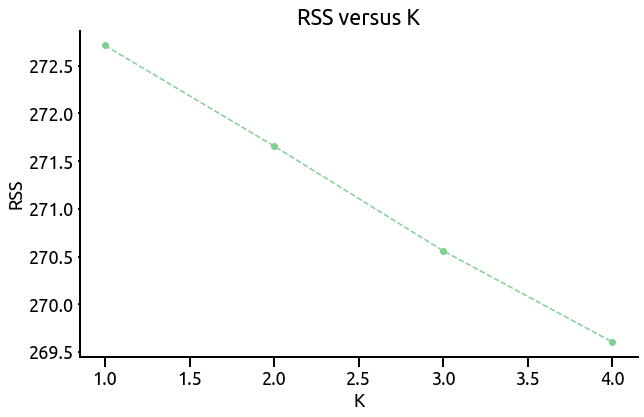

In [60]:
#num_clusters = 5
#km = KMeans(n_clusters=num_clusters)
#km.fit(tfidf_matrix)
#clusters = km.labels_.tolist()
#print(clusters)

X = tfidf_matrix
ncluster_list = range(1,5)
def kmean_score(nclust):
    km = KMeans(n_clusters = nclust, 
                init = 'random', 
                n_init = 10, 
                max_iter = 300, 
                n_jobs = -1) #look at hyperparameters
    km.fit(X)
    rss = -km.score(X)
    return rss

scores = [kmean_score(i) for i in ncluster_list]
print("#clust\trss")
for i, score in enumerate(scores):
    print("{0}\t{1:0.0f}".format(ncluster_list[i],score))
    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(ncluster_list, scores, 'o--', color=palette[1])
ax.set_xlabel('K')
ax.set_ylabel('RSS')
ax.set_title('RSS versus K');

In [61]:
ncluster_list = range(1,20)
ncluster_list

range(1, 20)

# PCA - tfidf

In [62]:
# see a 2d representation of the data using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)


X_tfidf_scaled = scaler.fit_transform(tfidf_matrix.todense()) # standardize data

pca_tfidf = PCA(n_components=2) #pca object
X_pca_tfidf = pca_tfidf.fit_transform(X_tfidf_scaled) # from 4 features to 2 PCA features

print("\nData after PCA into 2 components")
print("PC1\tPC2")
for i in range(3):
    print("{0:0.1f}\t{1:0.1f}".format(X_pca_tfidf[i,0], X_pca_tfidf[i,1]))


Data after PCA into 2 components
PC1	PC2
-2.8	-1.9
-2.6	-2.0
-2.5	-1.8


In [63]:
# How are each of the 2 principal components defined?
# Here are the loadings (how the original features load on to the principal components)
pca_tfidf.components_.round(2)

array([[-0.  , -0.  , -0.  , ..., -0.  , -0.  , -0.  ],
       [-0.  , -0.  , -0.  , ..., -0.  ,  0.03,  0.03]])

In [64]:
# Are these components orthogonal?  (They should be!)
np.dot(pca_tfidf.components_[0], pca_tfidf.components_[1])

-6.071532165918825e-18

In [65]:
def plot_2_pca_comps(X_pca):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.scatter(X_pca[:, 0], X_pca[:, 1],
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title("First two PCA directions")
    ax.set_xlabel("1st eigenvector (PC1)")
    ax.set_ylabel("2nd eigenvector (PC2)");
    plt.show()

In [66]:
type(X_pca_tfidf)

numpy.ndarray

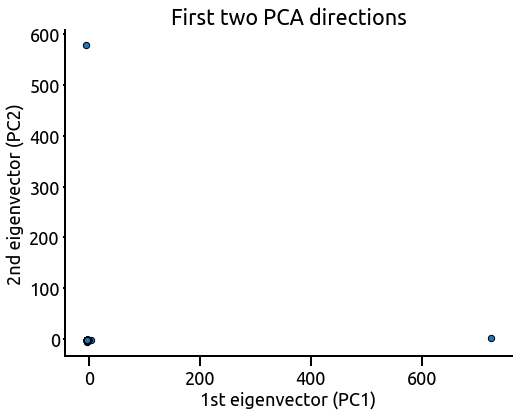

In [67]:
plot_2_pca_comps(X_pca_tfidf)

In [68]:
def scree_plot(pca):
    # plot explained variance ratio in a scree plot
    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.axes([.2, .2, .7, .7])
    plt.plot(pca.explained_variance_, linewidth=2, color=palette[0])
    plt.axis('tight')
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_')
    plt.show()
    
def cum_scree_plot(pca):
    total_variance = np.sum(pca.explained_variance_)
    cum_variance = np.cumsum(pca.explained_variance_)
    prop_var_expl = cum_variance/total_variance

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(prop_var_expl, color=palette[0], linewidth=2, label='Explained variance')
    ax.axhline(0.9, label='90% goal', linestyle='--', color="black", linewidth=1)
    ax.set_ylabel('cumulative prop. of explained variance')
    ax.set_xlabel('number of principal components')
    ax.legend()
    plt.show()

In [69]:
type(X_tfidf_scaled)

numpy.ndarray

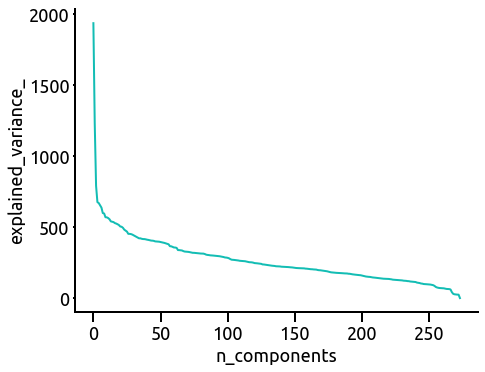

In [70]:
pca = PCA()
pca.fit(X_tfidf_scaled)
scree_plot(pca)

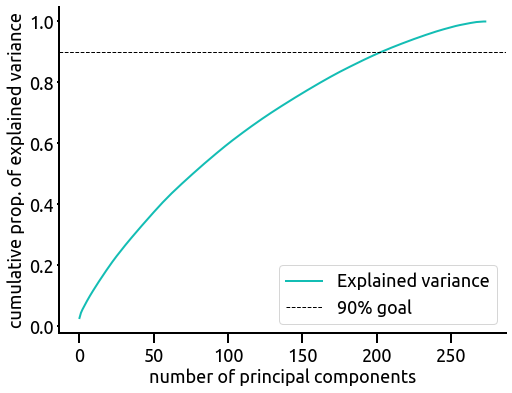

In [71]:
cum_scree_plot(pca)

# PCA -tf

In [72]:
X_tf_scaled = scaler.fit_transform(tf_matrix.todense()) # standardize data

pca_2 = PCA(n_components=2) #pca object
X_pca_tf = pca_tf.fit_transform(X_tf_scaled) # from 4 features to 2 PCA features

print("\nData after PCA into 2 components")
print("PC1\tPC2")
for i in range(3):
    print("{0:0.1f}\t{1:0.1f}".format(X_pca_tf[i,0], X_pca_tf[i,1]))


Data after PCA into 2 components
PC1	PC2
-0.7	-0.3
-0.7	-0.3
-0.7	-0.7


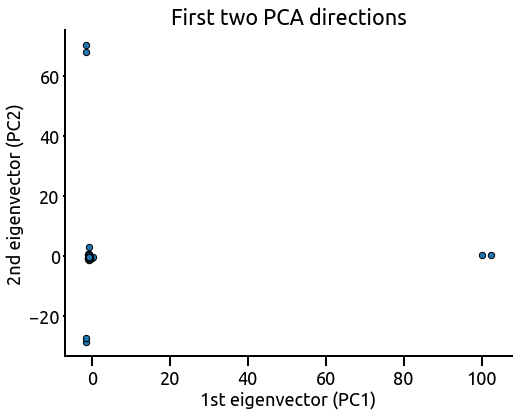

In [73]:
plot_2_pca_comps(X_pca_tf)

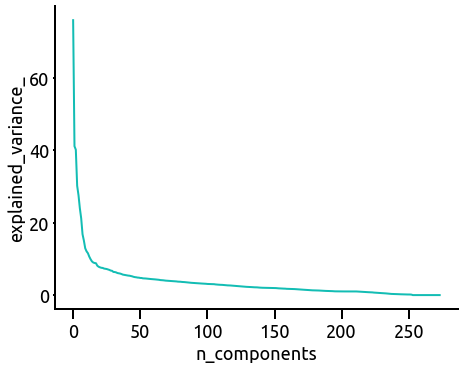

In [74]:
pca2 = PCA()
pca2.fit(X_tf_scaled)
scree_plot(pca2)

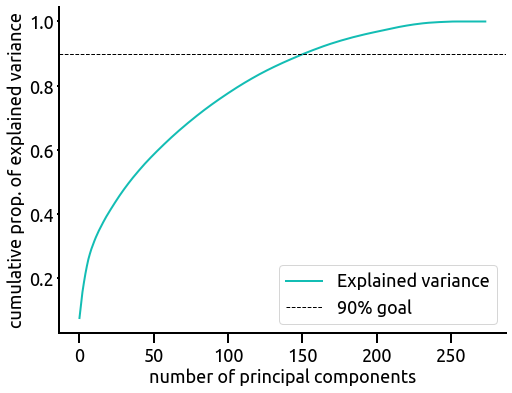

In [75]:
cum_scree_plot(pca2)